## Installing Dependencies

In [ ]:
!pip install pandas
! python3 -m pip install scikit-learn

In [ ]:
! pip install optuna
! pip install transformers[optuna]

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import pandas as pd
import numpy as np

## 1. Data Loading and Preprocessing.

In [ ]:
df = pd.read_csv('imdb_dataset')
# Display the first few rows of the dataframe
df.head(3)

,Unnamed: 0.1,Unnamed: 0,tconst,title,release_year,release_date,runtime,plot_short,plot_long,imdb_rating,num_imdb_votes,num_user_reviews,num_critic_reviews,genre
0,0,0,tt0010323,Das Cabinet des Dr. Caligari,1920,27 February 1920,67,"Hypnotist Dr. Caligari uses a somnambulist, Ce...","Francis, a young man, recalls in his memory th...",8.1,52815,222.0,156.0,"['fantasy', 'horror', 'mystery', 'thriller']"
1,1,1,tt0011237,"Der Golem, wie er in die Welt kam",1920,19 June 1921,91,"In 16th-century Prague, a rabbi creates the Go...","In 16th-century Prague, a rabbi creates the Go...",7.2,6136,49.0,45.0,"['fantasy', 'horror']"
2,2,2,tt0011841,Way Down East,1920,3 September 1920,145,A naive country girl is tricked into a sham ma...,"The callous rich, portrayed by Lennox, think o...",7.4,4800,49.0,28.0,"['drama', 'romance']"


### Observation
<p> The dataset contains a number of columns related to the movie present in the title column. "release_year", "plot_long","plot_short","imdb_rating" etc., are some of the important columns present. </p>

In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'tconst', 'title', 'release_year',
       'release_date', 'runtime', 'plot_short', 'plot_long', 'imdb_rating',
       'num_imdb_votes', 'num_user_reviews', 'num_critic_reviews', 'genre'],
      dtype='object')

<p> Removing unimportant columns from our dataset</p>

In [ ]:
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'tconst'], axis = 1)
df.head(2)

,title,release_year,release_date,runtime,plot_short,plot_long,imdb_rating,num_imdb_votes,num_user_reviews,num_critic_reviews,genre
0,Das Cabinet des Dr. Caligari,1920,27 February 1920,67,"Hypnotist Dr. Caligari uses a somnambulist, Ce...","Francis, a young man, recalls in his memory th...",8.1,52815,222.0,156.0,"['fantasy', 'horror', 'mystery', 'thriller']"
1,"Der Golem, wie er in die Welt kam",1920,19 June 1921,91,"In 16th-century Prague, a rabbi creates the Go...","In 16th-century Prague, a rabbi creates the Go...",7.2,6136,49.0,45.0,"['fantasy', 'horror']"


### Observation
<p> Our dataset has a genre column (target variable) which has multiple genres/labels present for a movie. Our aim in this project is to correctly predict the multiple labels present for a movie. </p>

In [ ]:
df['plot_long'][0], df['plot_short'][0],df['title'][0], df['genre'][0]

("Francis, a young man, recalls in his memory the horrible experiences he and his fiancée Jane recently went through. It is the annual fair in Holstenwall. Francis and his friend Alan visit The Cabinet of Dr. Caligari, an exhibit where the mysterious doctor shows the somnambulist Cesare, and awakens him for some moments from his death-like sleep. When Alan asks Cesare about his future, Cesare answers that he will die before dawn. The next morning Alan is found dead. Francis suspects Cesare of being the murderer, and starts spying on him and Dr. Caligari. The following night Cesare is going to stab Jane in her bed, but softens when he sees the beautiful woman, and instead of committing another murder, he abducts her. Jane's father awakens because of the noise, and he and some servants follow the fleeing Cesare. When Cesare cannot outrun his pursuers anymore, he gently places Jane down on the ground, and runs away. Francis and the police investigate the caravan of Dr. Caligari, but the .

### Intializing the BERT Model

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
df['tokens'] = df['plot_long'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
df['input_ids'] = df['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

In [ ]:
max_length = 128
# Pad input sequences
df['input_ids'] = df['input_ids'].apply(lambda x: np.array(x[:max_length] + [0] * (max_length - len(x))))

In [ ]:
print(df[['plot_long', 'tokens', 'input_ids']].head(2))

                                           plot_long  \
0  Francis, a young man, recalls in his memory th...   
1  In 16th-century Prague, a rabbi creates the Go...   

                                              tokens  \
0  [francis, ,, a, young, man, ,, recalls, in, hi...   
1  [in, 16th, -, century, prague, ,, a, rabbi, cr...   

                                           input_ids  
0  [4557, 1010, 1037, 2402, 2158, 1010, 17722, 19...  
1  [1999, 5767, 1011, 2301, 8634, 1010, 1037, 790...  


In [ ]:
df['attention_mask'] = df['input_ids'].apply(lambda x: [1] * len(x))

In [ ]:
df.columns

Index(['title', 'release_year', 'release_date', 'runtime', 'plot_short',
       'plot_long', 'imdb_rating', 'num_imdb_votes', 'num_user_reviews',
       'num_critic_reviews', 'genre', 'tokens', 'input_ids', 'attention_mask'],
      dtype='object')

### Observation
<p> THe task of  predicting the labels for a movie will best achieved if we use the "plot_long" column. The reason for choosing this column is that our model requires some contextual information about the movie, to learn about the different genres present. "plot_long" provides us with more information compared to "plot_short".



In [ ]:
columns_to_drop = ['title','release_year','release_date','runtime','plot_short','plot_long','imdb_rating','num_imdb_votes','num_user_reviews','num_critic_reviews']
df_modified = df.drop(columns_to_drop, axis=1)

In [ ]:
df_modified.head(3)

,genre,tokens,input_ids,attention_mask
0,"['fantasy', 'horror', 'mystery', 'thriller']","[francis, ,, a, young, man, ,, recalls, in, hi...","[4557, 1010, 1037, 2402, 2158, 1010, 17722, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"['fantasy', 'horror']","[in, 16th, -, century, prague, ,, a, rabbi, cr...","[1999, 5767, 1011, 2301, 8634, 1010, 1037, 790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"['drama', 'romance']","[the, call, ##ous, rich, ,, portrayed, by, len...","[1996, 2655, 3560, 4138, 1010, 6791, 2011, 210...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
total_list = []
for labels in df_modified["genre"]:
  labels_list = eval(labels.strip("[]"))
  total_list.append(list(labels_list))
df_modified['genre'] = total_list
df_modified.head(4)

,genre,tokens,input_ids,attention_mask
0,"[fantasy, horror, mystery, thriller]","[francis, ,, a, young, man, ,, recalls, in, hi...","[4557, 1010, 1037, 2402, 2158, 1010, 17722, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[fantasy, horror]","[in, 16th, -, century, prague, ,, a, rabbi, cr...","[1999, 5767, 1011, 2301, 8634, 1010, 1037, 790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[drama, romance]","[the, call, ##ous, rich, ,, portrayed, by, len...","[1996, 2655, 3560, 4138, 1010, 6791, 2011, 210...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[drama, horror, sci-fi]","[based, on, the, robert, louis, stevenson, sto...","[2241, 2006, 1996, 2728, 3434, 13636, 2466, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### Observation
<p> Our Final Dataset is now ready for training. </p>

## Initializing the MultilabelBinazier

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [ ]:
df_modified["genre"][0:3]

0    [fantasy, horror, mystery, thriller]
1                       [fantasy, horror]
2                        [drama, romance]
Name: genre, dtype: object

In [ ]:
mlb.fit(df_modified['genre'])
# Transform the multi-label data into a sparse OHE representation
target_ohe = mlb.transform(df_modified['genre'])

### Observation
<p> We transform our genres into One Hot Encoded Vector representations for model training.

In [ ]:
df_modified.head(3)

,genre,tokens,input_ids,attention_mask
0,"[fantasy, horror, mystery, thriller]","[francis, ,, a, young, man, ,, recalls, in, hi...","[4557, 1010, 1037, 2402, 2158, 1010, 17722, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[fantasy, horror]","[in, 16th, -, century, prague, ,, a, rabbi, cr...","[1999, 5767, 1011, 2301, 8634, 1010, 1037, 790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[drama, romance]","[the, call, ##ous, rich, ,, portrayed, by, len...","[1996, 2655, 3560, 4138, 1010, 6791, 2011, 210...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
target_df = pd.DataFrame(target_ohe)
df_combined = pd.concat([df_modified, target_df], axis=1)

In [ ]:
df_combined.head(2)

,genre,tokens,input_ids,attention_mask,0,1,2,3,4,5,...,34,35,36,37,38,39,40,41,42,43
0,"[fantasy, horror, mystery, thriller]","[francis, ,, a, young, man, ,, recalls, in, hi...","[4557, 1010, 1037, 2402, 2158, 1010, 17722, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,"[fantasy, horror]","[in, 16th, -, century, prague, ,, a, rabbi, cr...","[1999, 5767, 1011, 2301, 8634, 1010, 1037, 790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_combined = df_combined.drop(['genre'],axis=1)

### Observation
<p> Our Final dataset is now ready with input_ids, attention_mask, tokens and OHE represented values of target variables (genres)

In [ ]:
df_combined.head(2)

,tokens,input_ids,attention_mask,0,1,2,3,4,5,6,...,34,35,36,37,38,39,40,41,42,43
0,"[francis, ,, a, young, man, ,, recalls, in, hi...","[4557, 1010, 1037, 2402, 2158, 1010, 17722, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,"[in, 16th, -, century, prague, ,, a, rabbi, cr...","[1999, 5767, 1011, 2301, 8634, 1010, 1037, 790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Splitting Data into Train and Test Dataframes

In [ ]:
from sklearn.model_selection import train_test_split

X = df_combined[['tokens', 'input_ids', 'attention_mask']]  # Features
y = df_combined.iloc[:, 3:]  # Target variables (all columns from index 3 onwards)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training data shapes:")
print(X_train.shape)
print(y_train.shape)

print("Testing data shapes:")
print(X_test.shape)
print(y_test.shape)

Training data shapes:
(22531, 3)
(22531, 44)
Testing data shapes:
(7511, 3)
(7511, 44)


### Observation
<p> Our dataset has 44 total differrent genres present. We have alloted 25% of the total data to our test dataset. We will train oour model on the remaining 75% of the data.

In [ ]:
X_train.head(2)

,tokens,input_ids,attention_mask
1261,"[bog, ##art, plays, a, man, convicted, of, mur...","[22132, 8445, 3248, 1037, 2158, 7979, 1997, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
11417,"[a, modest, man, is, suddenly, seized, from, h...","[1037, 10754, 2158, 2003, 3402, 8243, 2013, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## 3. Auto ML

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, input_ids, attention_mask, labels):
      self.input_ids = input_ids
      self.attention_mask = attention_mask
      self.labels = labels

  def __len__(self):
      return len(self.input_ids)

  def __getitem__(self, idx):
      item = {
          'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
          'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
          'labels': torch.tensor(self.labels[idx], dtype=torch.float)
      }
      return item

In [ ]:
train_dataset = CustomDataset(
    input_ids=X_train['input_ids'].tolist(),
    attention_mask=X_train['attention_mask'].tolist(),
    labels=y_train.values.tolist()
)
test_dataset = CustomDataset(
    input_ids=X_test['input_ids'].tolist(),
    attention_mask=X_test['attention_mask'].tolist(),
    labels= y_test.values.tolist()
)

In [ ]:
from transformers import BertForSequenceClassification, BertConfig
num_labels = 44  # Set the number of labels
# Load BERT with a configuration for multi-label classification
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels, problem_type="multi_label_classification")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import optuna
from transformers import Trainer, TrainingArguments

In [ ]:
def model_init():
  return BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

def hp_space(trial):
  return {
      'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True),
      'per_device_train_batch_size': trial.suggest_categorical('per_device_train_batch_size', [8, 16, 32]),
      'num_train_epochs': trial.suggest_int('num_train_epochs', 2, 4),
      'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.3),
      'warmup_steps': trial.suggest_int('warmup_steps', 0, 500)
  }

### Observation
<p> In the above given code we are defining the different Hyperparameters for a model e.g learning_rate, weight_decay etc. We will be automating the process of selecting the best hyperparameters tgrough auto Ml. We will select those parameters which give us the least value of Validation loss.

In [ ]:
def objective(trial):
    # Define the training arguments with the hyperparameters from the trial
  training_args = TrainingArguments(
      output_dir='./results',
      learning_rate=trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True),
      per_device_train_batch_size=trial.suggest_categorical('per_device_train_batch_size', [8, 16, 32]),
      num_train_epochs=trial.suggest_int('num_train_epochs', 2, 4),
      weight_decay=trial.suggest_float('weight_decay', 0.01, 0.3),
      warmup_steps=trial.suggest_int('warmup_steps', 0, 500),
      logging_dir='./logs',
      logging_steps=10,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      load_best_model_at_end=True,
      metric_for_best_model="loss",
  )
  trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )
  trainer.train()
  eval_results = trainer.evaluate()
  return eval_results['eval_loss']

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

[I 2024-06-09 13:52:51,085] A new study created in memory with name: no-name-3ade662b-e9fe-4938-9a05-8754a388342d
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.231200,0.225708
2,0.188500,0.198180
3,0.187000,0.184792
4,0.167000,0.181537


[I 2024-06-09 14:05:01,531] Trial 0 finished with value: 0.18153683841228485 and parameters: {'learning_rate': 1.2396871191869623e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 0.22045660555177576, 'warmup_steps': 16}. Best is trial 0 with value: 0.18153683841228485.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight'

Epoch,Training Loss,Validation Loss
1,0.234400,0.229425
2,0.210300,0.222243


[I 2024-06-09 14:11:22,820] Trial 1 finished with value: 0.2222432643175125 and parameters: {'learning_rate': 1.3596442178569547e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.24928382438741623, 'warmup_steps': 417}. Best is trial 0 with value: 0.18153683841228485.


In [ ]:
best_hyperparameters = study.best_params
print("Best Hyperparameters: ", best_hyperparameters)

Best Hyperparameters:  {'learning_rate': 1.2396871191869623e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 0.22045660555177576, 'warmup_steps': 16}


### Observation.
After running our Bert Model on 2 Epochs of validation data, we found out the following best hyperparameter values

1.   learning_rate: 1.2396871191869623e-05
2.   num_train_epochs: 4
3.   per_device_train_batch_size': 32
4.   weight_decay: 0.22045660555177576
5.   warmup_steps: 16

We will now train our model with these best hyperparameters learned/







In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=best_hyperparameters['learning_rate'],
    per_device_train_batch_size=best_hyperparameters['per_device_train_batch_size'],
    num_train_epochs=best_hyperparameters['num_train_epochs'],
    weight_decay=best_hyperparameters['weight_decay'],
    warmup_steps=best_hyperparameters['warmup_steps'],
    logging_dir='./logs',
    logging_steps=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize the Trainer with the best hyperparameters
trainer = Trainer(
    model=model_init(),  # Ensure you're using the model initialization function
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Model Evaluation

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.231500,0.217398
2,0.180400,0.195277
3,0.210300,0.183971
4,0.153300,0.181013


TrainOutput(global_step=2820, training_loss=0.20968294984905433, metrics={'train_runtime': 712.0881, 'train_samples_per_second': 126.563, 'train_steps_per_second': 3.96, 'total_flos': 5930390701879296.0, 'train_loss': 0.20968294984905433, 'epoch': 4.0})

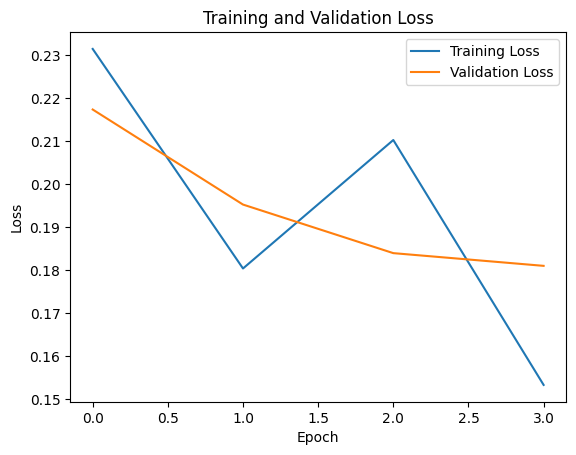

In [ ]:
import matplotlib.pyplot as plt
training_loss = [0.2315, 0.1804,0.2103,0.1533]
val_loss = [0.217398,0.195277,0.183971,0.181013]
plt.plot(training_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Observation
<p> We see that the training and validation loss are in sync with each other. The model is not overfitting and both the training and the validation loss are decreasing in sync with each other. Due to memory constraints we will be training our model for only 2 Epochs </p>

In [ ]:
eval_results = trainer.evaluate()
print("Evaluation Results: ", eval_results)

Evaluation Results:  {'eval_loss': 0.18101342022418976, 'eval_runtime': 17.4255, 'eval_samples_per_second': 431.034, 'eval_steps_per_second': 53.886, 'epoch': 4.0}


## 5. Test Data Evaluation

In [ ]:
import random
import torch

# Number of samples to pick
num_samples = 5
random_indices = random.sample(range(len(test_dataset)), num_samples)
random_samples = [test_dataset[i] for i in random_indices]

In [ ]:
input_ids = torch.stack([sample['input_ids'] for sample in random_samples]).to(model.device)
attention_mask = torch.stack([sample['attention_mask'] for sample in random_samples]).to(model.device)

In [ ]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
probabilities = torch.sigmoid(outputs.logits)
predictions = (probabilities > 0.5).int().cpu().numpy()  # Threshold at 0.5
labels = torch.stack([sample['labels'] for sample in random_samples]).cpu().numpy()

### Observation
<p> We randomly sample 5 test samples from our dataset and check the model performance on them. We can see that the model is predicting some correct instances of genres with some additional noise present. To achieve higher precision on our dataset we need to train this model on more epochs and GPU's

In [ ]:
for i in range(num_samples):
    print(f"Sample {i+1}:")
    print("Predicted Labels: ", predictions[i])
    print("Actual Labels:    ", labels[i])
    print()

Sample 1:
Predicted Labels:  [0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0
 1 1 1 0 1 0 0]
Actual Labels:     [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Sample 2:
Predicted Labels:  [0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0
 1 1 1 0 1 0 1]
Actual Labels:     [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Sample 3:
Predicted Labels:  [1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0
 0 0 0 0 1 1 1]
Actual Labels:     [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]

Sample 4:
Predicted Labels:  [1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0
 0 1 0 0 1 1 1]
Actual Labels:     [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.